# 📊 [TRAIN]My_Simple_Baseline

## 🎯 目的
データの前処理 -> 学習・推論 -> アウトプット -> 可視化分析まで実行

## 🔄 25.12.26: 主な改良点
1. **Config の統合**: すべての設定を一元管理
2. **Preprocessor の改善**: Config ベースで制御、密行列統合
3. **モデル学習の改善**: 正しい目的変数、LabelEncoding、OOF保存
4. **可視化・分析**: 分布比較、Feature Importance、Confusion Matrix

---

In [1]:
# ======================
# 📦 Import libraries
# ======================
import os, gc, re, yaml, glob, pickle, warnings
import time
import random, math
import joblib, itertools
from pathlib import Path

import numpy as np
import scipy as sp
import polars as pl
import pandas as pd
from tqdm.auto import tqdm
from typing import Union, Any, Dict, Optional, List, Tuple
from types import SimpleNamespace

# 化学系ライブラリ
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors, Lipinski, Crippen
from rdkit.Chem import rdFingerprintGenerator

# 可視化
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_fontja

# Cross validation
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder

# Model
import lightgbm as lgb

# Metrics
from sklearn.metrics import (
    roc_auc_score, roc_curve, 
    root_mean_squared_error, mean_squared_error,
    confusion_matrix, classification_report
)
from scipy.stats import spearmanr

# W&B
import wandb
from kaggle_secrets import UserSecretsClient

from datetime import datetime
date = datetime.now().strftime("%Y%m%d")
print(f"✅ TODAY is {date}")

warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, an

✅ TODAY is 20251226


In [2]:
# ==========================
# 🔧 W&B Setup
# ==========================
os.environ["WANDB_ENTITY"] = "hidebu"
os.environ["WANDB_PROJECT"] = "DSOW2025-improved-baseline"
os.environ["WANDB_BASE_URL"] = "https://toyota.wandb.io"

secret_label = "wandb_tmc_key"
os.environ["WANDB_API_KEY"] = UserSecretsClient().get_secret(secret_label)

BASE_GROUP = os.environ.get("WANDB_BASE_GROUP", "")
if not BASE_GROUP:
    BASE_GROUP = f"lc-improved-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
    os.environ["WANDB_BASE_GROUP"] = BASE_GROUP

print("✅ W&B Entity:", os.environ.get("WANDB_ENTITY"))
print("✅ W&B Project:", os.environ.get("WANDB_PROJECT"))
print("✅ Base Group:", BASE_GROUP)

✅ W&B Entity: hidebu
✅ W&B Project: DSOW2025-improved-baseline
✅ Base Group: lc-improved-20251226-055551


In [3]:
# ===============
# 🎛️ Config Class
# ===============
class Config:
    """統合設定クラス"""
    
    def __init__(self):
        # === 基本設定 ===
        self.seed = 42
        self.n_splits = 5
        self.data_dir = Path("/kaggle/input/data-science-osaka-winter-2025")
        self.output_dir = Path("/kaggle/working")
        self.output_dir.mkdir(exist_ok=True, parents=True)
        
        # === Preprocessor 設定 ===
        self.preprocessor = SimpleNamespace(
            verbose=True,
            n_bits=2048,  # ECFP4のビット数
            radius=2,  # ECFP4の半径
            tfidf_ngram_range=(1, 2), # 重要要素
            tfidf_min_df=2,
            tfidf_max_features=5000,  # TF-IDFの最大特徴量数
            include_molecular=True,
            include_name=True,
            include_phase=True,
            include_ecfp4=True,
            include_tfidf=True,
        )
        
        # === モデル設定 ===
        self.model = SimpleNamespace(
            # 分類タスク
            classification=dict(
                objective="binary",
                metric=["binary_logloss"],
                learning_rate=0.03,
                num_leaves=63,
                min_data_in_leaf=30,
                feature_fraction=0.9,
                bagging_fraction=0.9,
                bagging_freq=1,
                lambda_l1=0.1,
                lambda_l2=0.1,
                seed=42,
                verbosity=-1,
                num_boost_round=5000,
                early_stopping_rounds=500,
            ),
            # 回帰タスク
            regression=dict(
                objective="regression",
                metric=["rmse"],
                learning_rate=0.02,
                num_leaves=63,
                min_data_in_leaf=10,
                feature_fraction=0.9,
                bagging_fraction=0.9,
                bagging_freq=1,
                lambda_l1=0.1,
                lambda_l2=0.1,
                seed=42,
                verbosity=-1,
                num_boost_round=20000,
                early_stopping_rounds=500,
            )
        )
        
        # === W&B 設定 ===
        self.wandb = SimpleNamespace(
            use_wandb=True,
            entity=os.environ.get("WANDB_ENTITY"),
            project=os.environ.get("WANDB_PROJECT"),
            base_group=os.environ.get("WANDB_BASE_GROUP"),
        )
        
        # === 可視化設定 ===
        self.viz = SimpleNamespace(
            figsize=(15, 5),
            dpi=100,
            top_n_features=30,
        )

config = Config()
print(f"✅ Config initialized: seed={config.seed}, n_splits={config.n_splits}")

✅ Config initialized: seed=42, n_splits=5


In [4]:
# ========== 🛠️ Utils ==========
def sep(word: str, num: int = 80):
    """セパレータ付きメッセージ表示"""
    print("=" * num)
    print(f"✨ {word}")
    print("=" * num)

def show_df(df: Union[pd.DataFrame, pl.DataFrame], num: int = 3, show_tail: bool = False):
    """DataFrameの概要表示"""
    print(f"📊 Shape: {df.shape}")
    display(df.head(num))
    if show_tail:
        display(df.tail(num))

def seed_everything(seed=42):
    """シード固定"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(seed=config.seed)
print(f"✅ Seed fixed: {config.seed}")

✅ Seed fixed: 42


---
# 1️⃣ データ読み込み

In [5]:
sep("📂 データ読み込み")

train_df = pl.read_csv(config.data_dir / "train.csv")
test_df = pl.read_csv(config.data_dir / "test.csv")

print(f"📊 Train: {train_df.shape}")
print(f"📊 Test: {test_df.shape}")

# Train/Test フラグを追加
train_df = train_df.with_columns(pl.lit(True).alias("is_train"))
test_df = test_df.with_columns(pl.lit(False).alias("is_train"))

# 結合
df = pl.concat([train_df, test_df], how="diagonal")
sep("結合後のデータ"); show_df(df)

✨ 📂 データ読み込み
📊 Train: (1020, 11)
📊 Test: (1127, 6)
✨ 結合後のデータ
📊 Shape: (2147, 12)


row_id,compound_name,smiles_guess,lc_type,phase_transition_behavior,description,smiles_source,group_id,is_liquid_crystal,is_thermotropic_lc,clearing_point_celsius,is_train
i64,str,str,str,str,str,str,str,bool,i64,f64,bool
0,"""4-[(4-nitrophenoxy)carbonyl]ph…","""CCCOc1cc(OC)ccc1C(=O)Oc1ccc(C(…","""Monotropic""","""Cr 147 I (N 97 I) (NF 85 N)""","""A tri-aryl ester comprising a …","""New_Gemini""","""paper_0437""",true,0,97.0,true
1,"""Poly[oxy(2,4,4,6,6,8,10,10,12,…","""*O[Si]1(C)O[Si](C)(C)C[Si](C)(…","""Thermotropic""","""M 240 I""","""A cyclolinear polyorganocarbos…","""New_Gemini""","""paper_0005""",true,1,240.0,true
2,"""2,5,9-Tris(3,4-dihexyloxypheny…","""CCCCCCCOc1c(OCCCCCCC)cc(-n2nc3…","""Thermotropic""","""Cr 100 M 225 I""","""A star-shaped heteroaromatic s…","""New_Gemini""","""paper_0034""",true,1,225.0,true


---
# 2️⃣ 前処理（改良版）

In [6]:
# ==============================================
# 🔧 LiquidCrystalPreprocessor - 改良版
# ==============================================
class LiquidCrystalPreprocessor:
    """液晶予測のための特徴量抽出クラス（改良版）
    
    主な変更点:
    - Config ベースでの制御
    - ECFP4・TF-IDF を密行列として出力
    - 疎行列を返さない設計
    """
    
    def __init__(self, config: Config):
        self.cfg = config.preprocessor
        self.verbose = self.cfg.verbose
        
        # TF-IDF Vectorizer
        from sklearn.feature_extraction.text import TfidfVectorizer
        self.tfidf_vectorizer = TfidfVectorizer(
            ngram_range=self.cfg.tfidf_ngram_range,
            min_df=self.cfg.tfidf_min_df,
            max_features=self.cfg.tfidf_max_features,
        ) if self.cfg.include_tfidf else None
        
        # 特徴量名の保存
        self._feature_names = {
            'molecular': [],
            'name': [],
            'phase': [],
            'ecfp4': [],
            'tfidf': []
        }
        
        # null値補完戦略
        self._null_filling = {
            'lc_type': 'Unknown',
            'phase_transition_behavior': '',
            'smiles_source': 'Unknown',
            'description': '',
        }
        
        if self.verbose:
            print("✅ Preprocessor initialized")
            print(f"   ECFP4: {self.cfg.n_bits} bits, radius={self.cfg.radius}")
            print(f"   TF-IDF: max_features={self.cfg.tfidf_max_features}")
    
    # ================================================
    # 🔧 null値処理
    # ================================================
    def handle_null_values(self, df: pl.DataFrame) -> pl.DataFrame:
        """null値を適切に処理"""
        if self.verbose:
            sep("🔧 null値の処理")
        
        df_filled = df.clone()
        
        for col, fill_value in self._null_filling.items():
            if col in df_filled.columns:
                null_count = df_filled[col].null_count()
                if null_count > 0:
                    if self.verbose:
                        print(f"🔄 {col}: {null_count}個のnullを '{fill_value}' で補完")
                    df_filled = df_filled.with_columns(
                        pl.col(col).fill_null(fill_value)
                    )
        
        if self.verbose:
            print("✅ null値の処理完了")
        
        return df_filled
    
    # ================================================
    # 🧪 分子特徴量
    # ================================================
    @staticmethod
    def _extract_molecular_descriptors(smiles: str) -> Dict[str, Any]:
        """SMILESから分子記述子を抽出"""
        mol = Chem.MolFromSmiles(smiles)
        
        if mol is None:
            return {
                'mol_weight': np.nan,
                'mol_num_atoms': np.nan,
                'mol_num_heavy_atoms': np.nan,
                'mol_num_carbons': np.nan,
                'mol_num_nitrogens': np.nan,
                'mol_num_oxygens': np.nan,
                'mol_num_aromatic_rings': np.nan,
                'mol_num_rings': np.nan,
                'mol_num_rotatable_bonds': np.nan,
                'mol_fraction_csp3': np.nan,
                'mol_num_h_acceptors': np.nan,
                'mol_num_h_donors': np.nan,
                'mol_logP': np.nan,
                'mol_tpsa': np.nan,
                'mol_has_cyano': False,
                'mol_has_biphenyl': False,
                'mol_has_ester': False,
            }
        
        features = {
            'mol_weight': Descriptors.MolWt(mol),
            'mol_num_atoms': mol.GetNumAtoms(),
            'mol_num_heavy_atoms': Descriptors.HeavyAtomCount(mol),
            'mol_num_carbons': sum(1 for a in mol.GetAtoms() if a.GetSymbol() == 'C'),
            'mol_num_nitrogens': sum(1 for a in mol.GetAtoms() if a.GetSymbol() == 'N'),
            'mol_num_oxygens': sum(1 for a in mol.GetAtoms() if a.GetSymbol() == 'O'),
            'mol_num_aromatic_rings': Descriptors.NumAromaticRings(mol),
            'mol_num_rings': Descriptors.RingCount(mol),
            'mol_num_rotatable_bonds': Descriptors.NumRotatableBonds(mol),
            'mol_fraction_csp3': Descriptors.FractionCSP3(mol),
            'mol_num_h_acceptors': Descriptors.NumHAcceptors(mol),
            'mol_num_h_donors': Descriptors.NumHDonors(mol),
            'mol_logP': Crippen.MolLogP(mol),
            'mol_tpsa': Descriptors.TPSA(mol),
            'mol_has_cyano': mol.HasSubstructMatch(Chem.MolFromSmarts('C#N')),
            'mol_has_biphenyl': mol.HasSubstructMatch(Chem.MolFromSmarts('c1ccc(cc1)c2ccccc2')),
            'mol_has_ester': mol.HasSubstructMatch(Chem.MolFromSmarts('C(=O)O')),
        }
        
        return features
    
    def add_molecular_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """分子特徴量を追加"""
        if not self.cfg.include_molecular:
            return df
        
        if self.verbose:
            sep("🧪 分子特徴量の抽出")
        
        df_pd = df.to_pandas()
        features_list = []
        
        iterator = tqdm(df_pd['smiles_guess'], desc="分子特徴量") if self.verbose else df_pd['smiles_guess']
        
        for smiles in iterator:
            features_list.append(self._extract_molecular_descriptors(smiles))
        
        features_df = pd.DataFrame(features_list)
        self._feature_names['molecular'] = list(features_df.columns)
        
        result_df = pd.concat([df_pd, features_df], axis=1)
        
        if self.verbose:
            print(f"✅ 抽出完了: {len(features_df.columns)}個の特徴量")
        
        return pl.from_pandas(result_df)
    
    # ================================================
    # 🏷️ 化合物名特徴量
    # ================================================
    @staticmethod
    def _extract_name_features(name: str) -> Dict[str, Any]:
        """化合物名から特徴量を抽出"""
        if not isinstance(name, str) or name is None or name == '':
            return {
                'name_length': 0,
                'name_num_digits': 0,
                'name_has_alkyl': False,
                'name_has_phenyl': False,
                'name_has_cyano': False,
            }
        
        name_lower = name.lower()
        
        features = {
            'name_length': len(name),
            'name_num_digits': len(re.findall(r'\d', name)),
            'name_has_alkyl': bool(re.search(r'alkyl', name_lower)),
            'name_has_phenyl': bool(re.search(r'phenyl', name_lower)),
            'name_has_cyano': bool(re.search(r'cyano', name_lower)),
        }
        
        return features
    
    def add_name_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """化合物名特徴量を追加"""
        if not self.cfg.include_name:
            return df
        
        if self.verbose:
            sep("🏷️ 化合物名特徴量の抽出")
        
        df_pd = df.to_pandas()
        features_list = []
        
        iterator = tqdm(df_pd['compound_name'], desc="化合物名特徴量") if self.verbose else df_pd['compound_name']
        
        for name in iterator:
            features_list.append(self._extract_name_features(name))
        
        features_df = pd.DataFrame(features_list)
        self._feature_names['name'] = list(features_df.columns)
        
        result_df = pd.concat([df_pd, features_df], axis=1)
        
        if self.verbose:
            print(f"✅ 抽出完了: {len(features_df.columns)}個の特徴量")
        
        return pl.from_pandas(result_df)
    
    # ================================================
    # 🌡️ 相転移特徴量
    # ================================================
    @staticmethod
    def _extract_phase_features(behavior: str) -> Dict[str, Any]:
        """相転移挙動から特徴量を抽出"""
        if not isinstance(behavior, str) or behavior is None or behavior == '':
            return {
                'phase_has_nematic': False,
                'phase_has_smectic': False,
                'phase_has_crystal': False,
                'phase_num_temperatures': 0,
                'phase_first_temp': np.nan,
                'phase_highest_temp': np.nan,
            }
        
        behavior_upper = behavior.upper()
        temperatures = [float(t) for t in re.findall(r'\d+\.?\d*', behavior)]
        
        features = {
            'phase_has_nematic': bool(re.search(r'\bN\b', behavior_upper)),
            'phase_has_smectic': bool(re.search(r'\bS[A-Z]?\b', behavior_upper)),
            'phase_has_crystal': bool(re.search(r'\bCR\b', behavior_upper)),
            'phase_num_temperatures': len(temperatures),
            'phase_first_temp': temperatures[0] if temperatures else np.nan,
            'phase_highest_temp': max(temperatures) if temperatures else np.nan,
        }
        
        return features
    
    def add_phase_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """相転移特徴量を追加"""
        if not self.cfg.include_phase or 'phase_transition_behavior' not in df.columns:
            return df
        
        if self.verbose:
            sep("🌡️ 相転移特徴量の抽出")
        
        df_pd = df.to_pandas()
        features_list = []
        
        iterator = tqdm(df_pd['phase_transition_behavior'], desc="相転移特徴量") if self.verbose else df_pd['phase_transition_behavior']
        
        for behavior in iterator:
            features_list.append(self._extract_phase_features(behavior))
        
        features_df = pd.DataFrame(features_list)
        self._feature_names['phase'] = list(features_df.columns)
        
        result_df = pd.concat([df_pd, features_df], axis=1)
        
        if self.verbose:
            print(f"✅ 抽出完了: {len(features_df.columns)}個の特徴量")
        
        return pl.from_pandas(result_df)
    
    # ================================================
    # 🧬 ECFP4（密行列で返す）
    # ================================================
    def add_ecfp4_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """ECFP4を密行列として追加"""
        if not self.cfg.include_ecfp4:
            return df
        
        if self.verbose:
            sep("🧬 ECFP4の生成")
        
        df_pd = df.to_pandas()
        smiles_list = df_pd['smiles_guess'].tolist()
        
        gen = rdFingerprintGenerator.GetMorganGenerator(
            radius=self.cfg.radius,
            fpSize=self.cfg.n_bits
        )
        
        ecfp4_array = np.zeros((len(smiles_list), self.cfg.n_bits), dtype=np.int8)
        
        iterator = tqdm(enumerate(smiles_list), total=len(smiles_list), desc="ECFP4生成") if self.verbose else enumerate(smiles_list)
        
        for i, smiles in iterator:
            mol = Chem.MolFromSmiles(str(smiles))
            if mol is not None:
                fp = gen.GetFingerprintAsNumPy(mol)
                ecfp4_array[i] = fp.astype(np.int8)
        
        # 密行列として DataFrame に変換
        ecfp4_df = pd.DataFrame(
            ecfp4_array,
            columns=[f'ecfp4_{i}' for i in range(self.cfg.n_bits)]
        )
        
        self._feature_names['ecfp4'] = list(ecfp4_df.columns)
        
        result_df = pd.concat([df_pd, ecfp4_df], axis=1)
        
        if self.verbose:
            print(f"✅ ECFP4生成完了: {self.cfg.n_bits}次元")
        
        return pl.from_pandas(result_df)
    
    # ================================================
    # 📝 TF-IDF（密行列で返す）
    # ================================================
    def add_tfidf_features(self, df: pl.DataFrame, fit: bool = True) -> pl.DataFrame:
        """TF-IDFを密行列として追加"""
        if not self.cfg.include_tfidf or 'description' not in df.columns:
            return df
        
        if self.verbose:
            sep("📝 TF-IDFの生成")
        
        df_pd = df.to_pandas()
        descriptions = df_pd['description'].fillna('')
        
        if fit:
            tfidf_matrix = self.tfidf_vectorizer.fit_transform(descriptions)
            self._feature_names['tfidf'] = self.tfidf_vectorizer.get_feature_names_out().tolist()
        else:
            tfidf_matrix = self.tfidf_vectorizer.transform(descriptions)
        
        # 密行列に変換
        tfidf_df = pd.DataFrame(
            tfidf_matrix.toarray(),
            columns=self._feature_names['tfidf']
        )
        
        result_df = pd.concat([df_pd, tfidf_df], axis=1)
        
        if self.verbose:
            print(f"✅ TF-IDF生成完了: {len(self._feature_names['tfidf'])}次元")
        
        return pl.from_pandas(result_df)
    
    # ================================================
    # 🔄 残りのnull値補完
    # ================================================
    def fill_remaining_nulls(self, df: pl.DataFrame) -> pl.DataFrame:
        """前処理後に残っているnull値を補完"""
        if self.verbose:
            sep("🔧 残りのnull値補完")
        
        df_filled = df.clone()
        
        for col in df_filled.columns:
            null_count = df_filled[col].null_count()
            if null_count > 0:
                col_dtype = str(df_filled[col].dtype)
                
                if 'Float' in col_dtype or 'Int' in col_dtype:
                    df_filled = df_filled.with_columns(pl.col(col).fill_null(0))
                elif 'Boolean' in col_dtype or col_dtype == 'Bool':
                    df_filled = df_filled.with_columns(pl.col(col).fill_null(False))
                elif 'Utf8' in col_dtype or 'String' in col_dtype:
                    df_filled = df_filled.with_columns(pl.col(col).fill_null(''))
        
        if self.verbose:
            remaining = sum(df_filled[col].null_count() for col in df_filled.columns)
            print(f"✅ 補完完了: 残りnull数 = {remaining}")
        
        return df_filled
    
    # ================================================
    # 🚀 統合処理
    # ================================================
    def fit_transform(self, df: pl.DataFrame) -> pl.DataFrame:
        """全特徴量を抽出（学習時）"""
        if self.verbose:
            sep("🚀 特徴量エンジニアリング開始")
        
        start_time = time.time()
        
        df = self.handle_null_values(df)
        df = self.add_molecular_features(df)
        df = self.add_name_features(df)
        df = self.add_phase_features(df)
        df = self.add_ecfp4_features(df)
        df = self.add_tfidf_features(df, fit=True)
        df = self.fill_remaining_nulls(df)
        
        elapsed = time.time() - start_time
        
        if self.verbose:
            sep("✅ 特徴量エンジニアリング完了")
            print(f"📊 出力: {df.shape[0]}行 × {df.shape[1]}列")
            print(f"⏱️ 処理時間: {elapsed:.2f}秒")
        
        return df
    
    def transform(self, df: pl.DataFrame) -> pl.DataFrame:
        """学習時と同じ処理を適用（推論時）"""
        if self.verbose:
            sep("🔄 特徴量変換（推論モード）")
        
        start_time = time.time()
        
        df = self.handle_null_values(df)
        df = self.add_molecular_features(df)
        df = self.add_name_features(df)
        df = self.add_phase_features(df)
        df = self.add_ecfp4_features(df)
        df = self.add_tfidf_features(df, fit=False)
        df = self.fill_remaining_nulls(df)
        
        elapsed = time.time() - start_time
        
        if self.verbose:
            sep("✅ 特徴量変換完了")
            print(f"⏱️ 処理時間: {elapsed:.2f}秒")
        
        return df

In [7]:
# ==============================================
# 🔧 前処理の実行
# ==============================================
preprocessor = LiquidCrystalPreprocessor(config)

# 学習データ
df_train_processed = preprocessor.fit_transform(train_df)
sep("Train 前処理完了"); show_df(df_train_processed)

# テストデータ
df_test_processed = preprocessor.transform(test_df)
sep("Test 前処理完了"); show_df(df_test_processed)

# null値の最終確認
train_nulls = sum(df_train_processed[col].null_count() for col in df_train_processed.columns)
test_nulls = sum(df_test_processed[col].null_count() for col in df_test_processed.columns)

print(f"\n📊 null値の最終確認:")
print(f"   Train: {train_nulls}個")
print(f"   Test: {test_nulls}個")

if train_nulls == 0 and test_nulls == 0:
    print("✅ 全てのnull値が補完されました！")
else:
    print("⚠️ まだnull値が残っています")

✅ Preprocessor initialized
   ECFP4: 2048 bits, radius=2
   TF-IDF: max_features=5000
✨ 🚀 特徴量エンジニアリング開始
✨ 🔧 null値の処理
🔄 lc_type: 181個のnullを 'Unknown' で補完
🔄 phase_transition_behavior: 425個のnullを '' で補完
🔄 smiles_source: 21個のnullを 'Unknown' で補完
✅ null値の処理完了
✨ 🧪 分子特徴量の抽出


分子特徴量:   0%|          | 0/1020 [00:00<?, ?it/s]

[05:55:52] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 49 50 51 52 76 77 78
[05:55:52] Can't kekulize mol.  Unkekulized atoms: 16 17 19
[05:55:52] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 48 63 78
[05:55:52] Can't kekulize mol.  Unkekulized atoms: 13 14 15 105 106
[05:55:52] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 145 146 147
[05:55:52] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 54 55 56 57 84 85 86
[05:55:52] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 46 47 48 49 69 70 71
[05:55:52] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 81
[05:55:52] Can't kekulize mol.  Unkekulized atoms: 13 14 15 126 127
[05:55:52] Explicit valence for atom # 5 N, 3, is greater than permitted
[05:55:52] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43 85 86 87 88 130 131 132
[05:55:52] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 61 62 63 64 94 95 96
[05:55:52] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 39 40 41 42 61

✅ 抽出完了: 17個の特徴量
✨ 🏷️ 化合物名特徴量の抽出


化合物名特徴量:   0%|          | 0/1020 [00:00<?, ?it/s]

✅ 抽出完了: 5個の特徴量
✨ 🌡️ 相転移特徴量の抽出


相転移特徴量:   0%|          | 0/1020 [00:00<?, ?it/s]

✅ 抽出完了: 6個の特徴量
✨ 🧬 ECFP4の生成


ECFP4生成:   0%|          | 0/1020 [00:00<?, ?it/s]

[05:55:54] Can't kekulize mol.  Unkekulized atoms: 21 22 23 24 25 49 50 51 52 76 77 78
[05:55:54] Can't kekulize mol.  Unkekulized atoms: 16 17 19
[05:55:54] Can't kekulize mol.  Unkekulized atoms: 12 13 14 15 48 63 78
[05:55:54] Can't kekulize mol.  Unkekulized atoms: 13 14 15 105 106
[05:55:54] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 145 146 147
[05:55:54] Can't kekulize mol.  Unkekulized atoms: 23 24 25 26 27 54 55 56 57 84 85 86
[05:55:54] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 46 47 48 49 69 70 71
[05:55:54] Can't kekulize mol.  Unkekulized atoms: 64 65 66 67 81
[05:55:54] Can't kekulize mol.  Unkekulized atoms: 13 14 15 126 127
[05:55:54] Explicit valence for atom # 5 N, 3, is greater than permitted
[05:55:54] Can't kekulize mol.  Unkekulized atoms: 39 40 41 42 43 85 86 87 88 130 131 132
[05:55:54] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 61 62 63 64 94 95 96
[05:55:54] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20 39 40 41 42 61

✅ ECFP4生成完了: 2048次元
✨ 📝 TF-IDFの生成
✅ TF-IDF生成完了: 5000次元
✨ 🔧 残りのnull値補完
✅ 補完完了: 残りnull数 = 0
✨ ✅ 特徴量エンジニアリング完了
📊 出力: 1020行 × 7088列
⏱️ 処理時間: 3.63秒
✨ Train 前処理完了
📊 Shape: (1020, 7088)


row_id,compound_name,smiles_guess,lc_type,phase_transition_behavior,description,smiles_source,group_id,is_liquid_crystal,is_thermotropic_lc,clearing_point_celsius,is_train,mol_weight,mol_num_atoms,mol_num_heavy_atoms,mol_num_carbons,mol_num_nitrogens,mol_num_oxygens,mol_num_aromatic_rings,mol_num_rings,mol_num_rotatable_bonds,mol_fraction_csp3,mol_num_h_acceptors,mol_num_h_donors,mol_logP,mol_tpsa,mol_has_cyano,mol_has_biphenyl,mol_has_ester,name_length,name_num_digits,name_has_alkyl,name_has_phenyl,name_has_cyano,phase_has_nematic,phase_has_smectic,phase_has_crystal,…,with sulfonate,with terminal,with tert,with tetradecyl,with tetradecyloxy,with tetrafluoroborate,with the,with three,with trans,with trifluoromethyl,with tris,with two,with vinyl,withdrawing,within,within its,within surfactant,within the,within this,without,xylose,xylose with,xyloside,xyloside sugar,yellow,yield,yield the,yielding,yl,yl difluorobenzoate,yl dioxan,yl group,yl moiety,zeolitic,zeolitic imidazolate,zinc,zwitterionic
i64,str,str,str,str,str,str,str,bool,i64,f64,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,bool,i64,i64,bool,bool,bool,bool,bool,bool,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,"""4-[(4-nitrophenoxy)carbonyl]ph…","""CCCOc1cc(OC)ccc1C(=O)Oc1ccc(C(…","""Monotropic""","""Cr 147 I (N 97 I) (NF 85 N)""","""A tri-aryl ester comprising a …","""New_Gemini""","""paper_0437""",true,0,97.0,true,451.431,33.0,33.0,24.0,1.0,8.0,3.0,3.0,9.0,0.166667,8.0,0.0,4.8306,114.2,false,false,true,62,4,false,true,false,true,false,true,…,0.0,0.11612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"""Poly[oxy(2,4,4,6,6,8,10,10,12,…","""*O[Si]1(C)O[Si](C)(C)C[Si](C)(…","""Thermotropic""","""M 240 I""","""A cyclolinear polyorganocarbos…","""New_Gemini""","""paper_0005""",true,1,240.0,true,444.886,26.0,24.0,11.0,0.0,7.0,0.0,1.0,2.0,1.0,7.0,0.0,3.5352,64.61,false,false,false,79,17,false,false,false,false,false,false,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.146818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"""2,5,9-Tris(3,4-dihexyloxypheny…","""CCCCCCCOc1c(OCCCCCCC)cc(-n2nc3…","""Thermotropic""","""Cr 100 M 225 I""","""A star-shaped heteroaromatic s…","""New_Gemini""","""paper_0034""",true,1,225.0,true,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,false,false,false,94,17,false,true,false,false,false,true,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.253739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


✨ 🔄 特徴量変換（推論モード）
✨ 🔧 null値の処理
🔄 smiles_source: 41個のnullを 'Unknown' で補完
✅ null値の処理完了
✨ 🧪 分子特徴量の抽出


分子特徴量:   0%|          | 0/1127 [00:00<?, ?it/s]

[05:55:55] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 21
[05:55:56] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 39 40 41 42 43 44
[05:55:56] Can't kekulize mol.  Unkekulized atoms: 8 9 10
[05:55:56] Can't kekulize mol.  Unkekulized atoms: 17 18 19 59 60 61 62 63 83 84 85 87 88 89
[05:55:56] Explicit valence for atom # 38 N, 4, is greater than permitted
[05:55:56] Explicit valence for atom # 23 C, 5, is greater than permitted
[05:55:56] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 47 67 68 69 70
[05:55:56] Can't kekulize mol.  Unkekulized atoms: 107 108 115 116 117 118 119 126 133 134 135 136 143 150 151 152 153
[05:55:56] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27 51 75 78 81 84 85 109 110
[05:55:56] Can't kekulize mol.  Unkekulized atoms: 13 14 17 18 19 35 51 54 57 60 61 77 78
[05:55:56] Explicit valence for atom # 20 N, 4, is greater than permitted
[05:55:56] Can't kekulize mol.  Unkekulized atoms: 17 18 21 22 23 43 63 66 69 72 73 93 94
[0

✅ 抽出完了: 17個の特徴量
✨ 🏷️ 化合物名特徴量の抽出


[05:55:57] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 18 19 26 33 34 35 36 43 67 74 75
[05:55:57] Can't kekulize mol.  Unkekulized atoms: 13 14 15 17 18 19 27 28 30 31
[05:55:57] Can't kekulize mol.  Unkekulized atoms: 19 20 21 22 23 24 25 26 27 28 29 30 31


化合物名特徴量:   0%|          | 0/1127 [00:00<?, ?it/s]

✅ 抽出完了: 5個の特徴量
✨ 🧬 ECFP4の生成


ECFP4生成:   0%|          | 0/1127 [00:00<?, ?it/s]

[05:55:57] Can't kekulize mol.  Unkekulized atoms: 15 16 17 19 21
[05:55:57] Can't kekulize mol.  Unkekulized atoms: 28 29 30 31 32 33 34 39 40 41 42 43 44
[05:55:57] Can't kekulize mol.  Unkekulized atoms: 8 9 10
[05:55:57] Can't kekulize mol.  Unkekulized atoms: 17 18 19 59 60 61 62 63 83 84 85 87 88 89
[05:55:57] Explicit valence for atom # 38 N, 4, is greater than permitted
[05:55:57] Explicit valence for atom # 23 C, 5, is greater than permitted
[05:55:57] Can't kekulize mol.  Unkekulized atoms: 42 43 44 45 47 67 68 69 70
[05:55:57] Can't kekulize mol.  Unkekulized atoms: 107 108 115 116 117 118 119 126 133 134 135 136 143 150 151 152 153
[05:55:57] Can't kekulize mol.  Unkekulized atoms: 21 22 25 26 27 51 75 78 81 84 85 109 110
[05:55:57] Can't kekulize mol.  Unkekulized atoms: 13 14 17 18 19 35 51 54 57 60 61 77 78
[05:55:57] Explicit valence for atom # 20 N, 4, is greater than permitted
[05:55:57] Can't kekulize mol.  Unkekulized atoms: 17 18 21 22 23 43 63 66 69 72 73 93 94
[0

✅ ECFP4生成完了: 2048次元
✨ 📝 TF-IDFの生成
✅ TF-IDF生成完了: 5000次元
✨ 🔧 残りのnull値補完
✅ 補完完了: 残りnull数 = 0
✨ ✅ 特徴量変換完了
⏱️ 処理時間: 3.36秒
✨ Test 前処理完了
📊 Shape: (1127, 7077)


row_id,compound_name,smiles_guess,description,smiles_source,group_id,is_train,mol_weight,mol_num_atoms,mol_num_heavy_atoms,mol_num_carbons,mol_num_nitrogens,mol_num_oxygens,mol_num_aromatic_rings,mol_num_rings,mol_num_rotatable_bonds,mol_fraction_csp3,mol_num_h_acceptors,mol_num_h_donors,mol_logP,mol_tpsa,mol_has_cyano,mol_has_biphenyl,mol_has_ester,name_length,name_num_digits,name_has_alkyl,name_has_phenyl,name_has_cyano,ecfp4_0,ecfp4_1,ecfp4_2,ecfp4_3,ecfp4_4,ecfp4_5,ecfp4_6,ecfp4_7,…,with sulfonate,with terminal,with tert,with tetradecyl,with tetradecyloxy,with tetrafluoroborate,with the,with three,with trans,with trifluoromethyl,with tris,with two,with vinyl,withdrawing,within,within its,within surfactant,within the,within this,without,xylose,xylose with,xyloside,xyloside sugar,yellow,yield,yield the,yielding,yl,yl difluorobenzoate,yl dioxan,yl group,yl moiety,zeolitic,zeolitic imidazolate,zinc,zwitterionic
i64,str,str,str,str,str,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,bool,bool,i64,i64,bool,bool,bool,i8,i8,i8,i8,i8,i8,i8,i8,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1020,"""Supramolecular complex of 4-[(…","""CCCCCCCCCCCOc1ccc(C(=O)Oc2ccc(…","""A 1:1 supramolecular complex f…","""New_Gemini""","""paper_0491""",false,833.47,60.0,60.0,49.0,4.0,6.0,5.0,5.0,24.0,0.346939,9.0,1.0,14.3737,132.03,false,false,true,139,8,false,true,false,0,0,0,0,0,0,0,0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1021,"""2,3,6,7,14,15-hexahydroxycyclo…","""Oc1cc2c(cc1O)Cc1cc(O)c(O)cc1Cc…","""A bowl-shaped macrocyclic orga…","""New_Gemini""","""paper_0578""",false,366.369,27.0,27.0,21.0,0.0,6.0,3.0,4.0,0.0,0.142857,6.0,6.0,3.006,121.38,false,false,false,44,8,false,false,false,0,0,0,0,0,0,0,0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1022,"""n-4O3""","""CCCCOCCCNC(NCCCOCCCC)=c1ccc(=C…","""n-4O3 is an aromatic organic s…","""ChemRxiv_Gemini_v10""","""paper_0291""",false,412.578,30.0,30.0,24.0,4.0,2.0,1.0,1.0,16.0,0.583333,6.0,2.0,2.54296,90.1,true,false,false,5,2,false,false,false,0,0,0,0,0,0,0,0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



📊 null値の最終確認:
   Train: 0個
   Test: 0個
✅ 全てのnull値が補完されました！


---
# 3️⃣ モデル学習（改良版）

In [8]:
# ==============================================
# 🎯 評価指標
# ==============================================
def calculate_decoupled_rank_score(
    y_true_cls: np.ndarray,
    y_true_tc: np.ndarray,
    pred_prob: np.ndarray,
    pred_tc: np.ndarray,
    return_components: bool = False
) -> Union[float, Tuple[float, float, float]]:
    """Decoupled Rank Score を計算"""
    
    # 分類: Normalized Gini
    sort_indices = np.argsort(pred_prob)
    y_sorted = y_true_cls[sort_indices]
    cumulative_positives = np.cumsum(y_sorted)
    total_positives = cumulative_positives[-1] if cumulative_positives.size else 0
    
    if total_positives == 0:
        normalized_gini = 0.0
    else:
        gini = (cumulative_positives.sum() / total_positives) - (len(y_sorted) + 1) / 2
        gini_max = (np.arange(1, len(y_sorted) + 1).sum()) - (len(y_sorted) + 1) / 2
        normalized_gini = gini / gini_max
    
    # 回帰: Spearman順位相関
    valid_mask = (y_true_cls == 1) & np.isfinite(y_true_tc) & np.isfinite(pred_tc)
    
    if valid_mask.sum() < 3:
        spearman_rho = 0.0
    else:
        correlation_result = spearmanr(y_true_tc[valid_mask], pred_tc[valid_mask])
        spearman_rho = float(correlation_result.correlation)
        if np.isnan(spearman_rho):
            spearman_rho = 0.0
    
    final_score = 0.5 * (normalized_gini + spearman_rho)
    
    if return_components:
        return final_score, normalized_gini, spearman_rho
    return final_score

In [9]:
# ==============================================
# 🏋️ Trainer Class 
# ==============================================
class LiquidCrystalTrainer:
    """液晶予測モデルの学習パイプライン（最終修正版）"""
    
    def __init__(self, config: Config):
        self.config = config
        self.models = {
            'classification': [],
            'regression': []
        }
        self.oof_predictions = {}
        self.fold_scores = []
        self.feature_importance = {}
        
        # 特徴量名を保存（重要！）
        self.feature_cols = None
    
    def _prepare_features(
        self,
        df: pl.DataFrame,
        fit: bool = True
    ) -> Tuple[np.ndarray, List[str]]:
        """特徴量とカテゴリカル変数の準備"""
        
        df_pd = df.to_pandas()
        
        # 使用する特徴量のカラム
        feature_cols = []
        
        # === ⚠️ 修正: カテゴリカル変数は全てテストデータに存在しないため使用しない ===
        # lc_type, phase_transition_behavior, smiles_source は全て除外
        
        # === Preprocessorで作成した特徴量のみ使用 ===
        preprocessor_features = (
            preprocessor._feature_names['molecular'] +
            preprocessor._feature_names['name'] +
            preprocessor._feature_names['ecfp4'] +
            preprocessor._feature_names['tfidf']
        )
        
        # ⚠️ Phase関連の特徴量もテストデータにはないため除外済み
        
        # 実際に存在する特徴量のみ追加
        for feat in preprocessor_features:
            if feat in df_pd.columns:
                feature_cols.append(feat)
        
        # === 学習時と推論時で特徴量を統一 ===
        if fit:
            # 学習時: 特徴量名を保存
            self.feature_cols = feature_cols
            
            print(f"✅ 特徴量準備完了: {len(feature_cols)}次元")
            print(f"   分子特徴量: {len(preprocessor._feature_names['molecular'])}個")
            print(f"   化合物名特徴量: {len(preprocessor._feature_names['name'])}個")
            print(f"   ECFP4: {len(preprocessor._feature_names['ecfp4'])}個")
            print(f"   TF-IDF: {len(preprocessor._feature_names['tfidf'])}個")
            print(f"   ⚠️  注意: lc_type, phase_transition_behavior, smiles_source は除外")
        else:
            # 推論時: 学習時と同じ特徴量を使用
            feature_cols = self.feature_cols
            
            # 存在しない特徴量があればエラー
            missing_features = [f for f in feature_cols if f not in df_pd.columns]
            if missing_features:
                print(f"⚠️  警告: {len(missing_features)}個の特徴量が見つかりません")
                print(f"   欠損特徴量（最初の5個）: {missing_features[:5]}")
                raise ValueError(f"テストデータに必要な特徴量が不足しています")
            
            print(f"✅ 特徴量準備完了: {len(feature_cols)}次元（学習時と一致）")
        
        # 特徴量行列を作成
        X = df_pd[feature_cols].values
        
        return X, feature_cols
    
    @property
    def verbose(self):
        """verboseプロパティ"""
        return self.config.preprocessor.verbose
    
    def train_cv(
        self,
        df_train: pl.DataFrame
    ) -> Dict:
        """Cross Validationで学習"""
        
        sep("🚀 Cross Validation 学習開始")
        
        # 特徴量の準備
        X, feature_cols = self._prepare_features(df_train, fit=True)
        
        # === 目的変数 ===
        df_pd = df_train.to_pandas()
        
        # 分類の目的変数は is_thermotropic_lc
        y_cls = df_pd['is_thermotropic_lc'].values.astype(int)
        y_tc = df_pd['clearing_point_celsius'].values.astype(float)
        groups = df_pd['group_id'].values
        
        print(f"📊 データ情報:")
        print(f"   サンプル数: {len(X)}")
        print(f"   特徴量数: {X.shape[1]}")
        print(f"   分割数: {self.config.n_splits}")
        print(f"   目的変数（分類）: is_thermotropic_lc")
        print(f"   目的変数（回帰）: clearing_point_celsius")
        
        # 目的変数の分布確認
        print(f"\n📊 目的変数の分布:")
        print(f"   is_thermotropic_lc=0: {(y_cls == 0).sum()}個 ({(y_cls == 0).sum() / len(y_cls) * 100:.1f}%)")
        print(f"   is_thermotropic_lc=1: {(y_cls == 1).sum()}個 ({(y_cls == 1).sum() / len(y_cls) * 100:.1f}%)")
        
        # OOF予測用配列
        n_samples = len(X)
        oof_prob = np.zeros(n_samples, dtype=float)
        oof_tc_pred = np.full(n_samples, np.nan, dtype=float)
        
        # 特徴量重要度
        fi_cls = np.zeros(X.shape[1], dtype=float)
        fi_tc = np.zeros(X.shape[1], dtype=float)
        
        # Stratified Group K-Fold
        sgkf = StratifiedGroupKFold(
            n_splits=self.config.n_splits,
            shuffle=True,
            random_state=self.config.seed
        )
        
        # 各Foldで学習
        for fold, (train_idx, valid_idx) in enumerate(sgkf.split(X, y_cls, groups)):
            sep(f"📊 Fold {fold + 1}/{self.config.n_splits}")
            
            X_train, X_valid = X[train_idx], X[valid_idx]
            y_train_cls, y_valid_cls = y_cls[train_idx], y_cls[valid_idx]
            y_train_tc, y_valid_tc = y_tc[train_idx], y_tc[valid_idx]
            
            print(f"   Train: {len(train_idx)} samples")
            print(f"   Valid: {len(valid_idx)} samples")
            print(f"   Train LC: {(y_train_cls == 1).sum()} samples")
            print(f"   Valid LC: {(y_valid_cls == 1).sum()} samples")
            
            # === 1. 分類タスク ===
            print(f"\n🔵 分類タスク（is_thermotropic_lc）")
            
            if self.config.wandb.use_wandb:
                wandb.init(
                    entity=self.config.wandb.entity,
                    project=self.config.wandb.project,
                    group=f"{self.config.wandb.base_group}-cls",
                    name=f"cls-fold{fold+1}",
                    job_type="train",
                    reinit=True,
                    config={
                        "task": "classification",
                        "fold": fold,
                        "params": self.config.model.classification,
                    }
                )
            
            train_data = lgb.Dataset(X_train, label=y_train_cls)
            valid_data = lgb.Dataset(X_valid, label=y_valid_cls, reference=train_data)
            
            callbacks = [
                lgb.early_stopping(self.config.model.classification['early_stopping_rounds'], verbose=False),
                lgb.log_evaluation(period=50),
            ]
            
            if self.config.wandb.use_wandb:
                from wandb.integration.lightgbm import wandb_callback
                callbacks.insert(0, wandb_callback())
            
            params_cls = {k: v for k, v in self.config.model.classification.items() 
                         if k not in ['num_boost_round', 'early_stopping_rounds']}
            
            booster_cls = lgb.train(
                params_cls,
                train_data,
                valid_sets=[valid_data],
                valid_names=["valid"],
                num_boost_round=self.config.model.classification['num_boost_round'],
                callbacks=callbacks,
            )
            
            # OOF予測
            oof_prob[valid_idx] = booster_cls.predict(X_valid, num_iteration=booster_cls.best_iteration)
            
            # 特徴量重要度
            fi_cls += booster_cls.feature_importance(importance_type="gain") / self.config.n_splits
            
            self.models['classification'].append(booster_cls)
            
            auc = roc_auc_score(y_valid_cls, oof_prob[valid_idx])
            print(f"   ✅ AUC: {auc:.5f}")
            
            if self.config.wandb.use_wandb:
                wandb.log({"fold/auc": auc})
                wandb.finish()
            
            # === 2. 回帰タスク（clearing_point_celsius） ===
            print(f"\n🟢 回帰タスク（clearing_point_celsius）")
            
            # ⚠️ is_thermotropic_lc==1 かつ clearing_point_celsius が有限値
            mask_train_lc = (y_train_cls == 1) & np.isfinite(y_train_tc)
            mask_valid_lc = (y_valid_cls == 1) & np.isfinite(y_valid_tc)
            
            print(f"   Train LC (有限値): {mask_train_lc.sum()} samples")
            print(f"   Valid LC (有限値): {mask_valid_lc.sum()} samples")
            
            if mask_train_lc.sum() >= 10 and mask_valid_lc.sum() >= 3:
                if self.config.wandb.use_wandb:
                    wandb.init(
                        entity=self.config.wandb.entity,
                        project=self.config.wandb.project,
                        group=f"{self.config.wandb.base_group}-tc",
                        name=f"tc-fold{fold+1}",
                        job_type="train",
                        reinit=True,
                        config={
                            "task": "regression_tc",
                            "fold": fold,
                            "params": self.config.model.regression,
                        }
                    )
                
                train_data_tc = lgb.Dataset(X_train[mask_train_lc], label=y_train_tc[mask_train_lc])
                valid_data_tc = lgb.Dataset(X_valid[mask_valid_lc], label=y_valid_tc[mask_valid_lc], reference=train_data_tc)
                
                callbacks = [
                    lgb.early_stopping(self.config.model.regression['early_stopping_rounds'], verbose=False),
                    lgb.log_evaluation(period=50),
                ]
                
                if self.config.wandb.use_wandb:
                    callbacks.insert(0, wandb_callback())
                
                params_reg = {k: v for k, v in self.config.model.regression.items() 
                             if k not in ['num_boost_round', 'early_stopping_rounds']}
                
                booster_tc = lgb.train(
                    params_reg,
                    train_data_tc,
                    valid_sets=[valid_data_tc],
                    valid_names=["valid"],
                    num_boost_round=self.config.model.regression['num_boost_round'],
                    callbacks=callbacks,
                )
                
                # OOF予測
                tc_pred_all = booster_tc.predict(X_valid, num_iteration=booster_tc.best_iteration)
                oof_tc_pred[valid_idx] = np.nan
                oof_tc_pred[valid_idx[mask_valid_lc]] = tc_pred_all[mask_valid_lc]
                
                # 特徴量重要度
                fi_tc += booster_tc.feature_importance(importance_type="gain") / self.config.n_splits
                
                self.models['regression'].append(booster_tc)
                
                rmse = root_mean_squared_error(y_valid_tc[mask_valid_lc], tc_pred_all[mask_valid_lc])
                print(f"   ✅ RMSE: {rmse:.5f}")
                
                if self.config.wandb.use_wandb:
                    wandb.log({"fold/rmse": rmse})
                    wandb.finish()
            else:
                print(f"   ⚠️ サンプル数不足のためスキップ")
                self.models['regression'].append(None)
            
            # === 3. Foldスコアの計算 ===
            score, norm_gini, spearman_rho = calculate_decoupled_rank_score(
                y_valid_cls, y_valid_tc,
                oof_prob[valid_idx], oof_tc_pred[valid_idx],
                return_components=True
            )
            
            self.fold_scores.append({
                'fold': fold + 1,
                'score': score,
                'norm_gini': norm_gini,
                'spearman': spearman_rho,
                'auc': auc
            })
            
            print(f"\n📊 Fold {fold + 1} スコア:")
            print(f"   Decoupled Rank Score: {score:.6f}")
            print(f"   Normalized Gini: {norm_gini:.6f}")
            print(f"   Spearman's rho: {spearman_rho:.6f}")
        
        # === 4. 全体のCVスコア ===
        sep("✅ Cross Validation 完了")
        
        cv_score, cv_gini, cv_rho = calculate_decoupled_rank_score(
            y_cls, y_tc, oof_prob, oof_tc_pred,
            return_components=True
        )
        
        print(f"\n📊 全体のCVスコア:")
        print(f"   Decoupled Rank Score: {cv_score:.6f}")
        print(f"   Normalized Gini: {cv_gini:.6f}")
        print(f"   Spearman's rho: {cv_rho:.6f}")
        
        # Fold別スコア表示
        print(f"\n📊 Fold別スコア:")
        fold_df = pd.DataFrame(self.fold_scores)
        display(fold_df)
        
        # OOFとFeature Importanceを保存
        self.oof_predictions = {
            'classification': oof_prob,
            'regression': oof_tc_pred
        }
        
        self.feature_importance = {
            'classification': fi_cls,
            'regression': fi_tc,
            'feature_names': feature_cols
        }
        
        # === 5. OOFを保存 & W&Bにアップロード ===
        self._save_oof(df_train.to_pandas(), y_cls, y_tc, oof_prob, oof_tc_pred)
        
        return {
            'cv_score': cv_score,
            'cv_gini': cv_gini,
            'cv_rho': cv_rho,
            'oof_predictions': self.oof_predictions,
            'fold_scores': self.fold_scores
        }
    
    def _save_oof(
        self,
        df_train: pd.DataFrame,
        y_cls: np.ndarray,
        y_tc: np.ndarray,
        oof_prob: np.ndarray,
        oof_tc_pred: np.ndarray
    ):
        """OOF予測を保存してW&Bにアップロード"""
        
        sep("💾 OOF予測の保存")
        
        oof_df = pd.DataFrame({
            'row_id': df_train['row_id'].values,
            'group_id': df_train['group_id'].values,
            'y_true_cls': y_cls,
            'y_true_tc': y_tc,
            'oof_prob': oof_prob,
            'oof_tc_pred': oof_tc_pred
        })
        
        # ローカルに保存
        oof_path = self.config.output_dir / 'oof_predictions.csv'
        oof_df.to_csv(oof_path, index=False)
        print(f"✅ OOFを保存: {oof_path}")
        
        # W&Bにアップロード
        if self.config.wandb.use_wandb:
            run = wandb.init(
                entity=self.config.wandb.entity,
                project=self.config.wandb.project,
                group=self.config.wandb.base_group,
                name="oof-predictions",
                job_type="oof",
                reinit=True
            )
            
            artifact = wandb.Artifact('oof-predictions', type='predictions')
            artifact.add_file(str(oof_path))
            run.log_artifact(artifact)
            
            run.finish()
            print("✅ OOFをW&Bにアップロード")
    
    def predict(self, df_test: pl.DataFrame) -> Dict[str, np.ndarray]:
        """テストデータで予測"""
        
        sep("🔮 テストデータで予測")
        
        X, _ = self._prepare_features(df_test, fit=False)
        
        print(f"📊 テストデータ特徴量: {X.shape}")
        
        n_samples = len(X)
        pred_prob = np.zeros(n_samples, dtype=float)
        pred_tc = np.zeros(n_samples, dtype=float)
        
        # 各Foldのモデルで予測して平均
        for fold, (model_cls, model_tc) in enumerate(
            zip(self.models['classification'], self.models['regression'])
        ):
            print(f"   Fold {fold + 1}: 予測中...")
            
            pred_prob += model_cls.predict(X, num_iteration=model_cls.best_iteration) / self.config.n_splits
            
            if model_tc is not None:
                pred_tc += model_tc.predict(X, num_iteration=model_tc.best_iteration) / self.config.n_splits
        
        print("✅ 予測完了")
        
        return {
            'classification': pred_prob,
            'regression': pred_tc
        }

In [10]:
# ==============================================
# 🏋️ モデル学習の実行
# ==============================================
trainer = LiquidCrystalTrainer(config)

# Cross Validationで学習
results = trainer.train_cv(df_train_processed)

# テストデータで予測
test_predictions = trainer.predict(df_test_processed)

# 提出ファイルの作成
submission = pd.DataFrame({
    'row_id': df_test_processed['row_id'].to_numpy(),
    'prediction': [
        f"[{prob:.6f}, {tc:.2f}]" 
        for prob, tc in zip(
            test_predictions['classification'],
            test_predictions['regression']
        )
    ]
})

sep("📤 Submission"); show_df(submission, 3, True)
submission_path = config.output_dir / 'submission.csv'
submission.to_csv(submission_path, index=False)
print(f"✅ submission.csv を作成: {submission_path}")

✨ 🚀 Cross Validation 学習開始
✅ 特徴量準備完了: 7070次元
   分子特徴量: 17個
   化合物名特徴量: 5個
   ECFP4: 2048個
   TF-IDF: 5000個
   ⚠️  注意: lc_type, phase_transition_behavior, smiles_source は除外
📊 データ情報:
   サンプル数: 1020
   特徴量数: 7070
   分割数: 5
   目的変数（分類）: is_thermotropic_lc
   目的変数（回帰）: clearing_point_celsius

📊 目的変数の分布:
   is_thermotropic_lc=0: 709個 (69.5%)
   is_thermotropic_lc=1: 311個 (30.5%)
✨ 📊 Fold 1/5
   Train: 803 samples
   Valid: 217 samples
   Train LC: 246 samples
   Valid LC: 65 samples

🔵 分類タスク（is_thermotropic_lc）


wandb: Currently logged in as: hidebu to https://toyota.wandb.io. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.
wandb: setting up run tkb7yspg
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251226_055602-tkb7yspg
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cls-fold1
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/tkb7yspg


[50]	valid's binary_logloss: 0.52155
[100]	valid's binary_logloss: 0.56543
[150]	valid's binary_logloss: 0.596477
[200]	valid's binary_logloss: 0.637492
[250]	valid's binary_logloss: 0.674209
[300]	valid's binary_logloss: 0.714217
[350]	valid's binary_logloss: 0.750079
[400]	valid's binary_logloss: 0.778805
[450]	valid's binary_logloss: 0.817452
[500]	valid's binary_logloss: 0.843344


wandb: updating run metadata


   ✅ AUC: 0.79130


wandb: uploading history steps 0-541, summary, console lines 0-10
wandb: 
wandb: Run history:
wandb:             fold/auc ▁
wandb:            iteration ▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
wandb: valid_binary_logloss ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇████
wandb: 
wandb: Run summary:
wandb:  fold/auc 0.7913
wandb: iteration 540
wandb: 
wandb: 🚀 View run cls-fold1 at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/tkb7yspg
wandb: ⭐️ View project at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251226_055602-tkb7yspg/logs



🟢 回帰タスク（clearing_point_celsius）
   Train LC (有限値): 246 samples
   Valid LC (有限値): 65 samples


wandb: setting up run 512k7199
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251226_055610-512k7199
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run tc-fold1
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/512k7199


[50]	valid's rmse: 55.4866
[100]	valid's rmse: 54.0435
[150]	valid's rmse: 54.7086
[200]	valid's rmse: 56.0282
[250]	valid's rmse: 56.8234
[300]	valid's rmse: 57.7397
[350]	valid's rmse: 58.4254
[400]	valid's rmse: 58.7575
[450]	valid's rmse: 59.215
[500]	valid's rmse: 59.407
[550]	valid's rmse: 59.5964
[600]	valid's rmse: 59.7426


wandb: updating run metadata


   ✅ RMSE: 53.86726


wandb: uploading history steps 0-621, summary, console lines 0-12
wandb: 
wandb: Run history:
wandb:  fold/rmse ▁
wandb:  iteration ▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
wandb: valid_rmse █▅▂▁▁▁▁▁▁▁▂▂▃▄▄▄▄▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████
wandb: 
wandb: Run summary:
wandb: fold/rmse 53.86726
wandb: iteration 620
wandb: 
wandb: 🚀 View run tc-fold1 at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/512k7199
wandb: ⭐️ View project at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251226_055610-512k7199/logs



📊 Fold 1 スコア:
   Decoupled Rank Score: 0.241015
   Normalized Gini: -0.001884
   Spearman's rho: 0.483914
✨ 📊 Fold 2/5
   Train: 809 samples
   Valid: 211 samples
   Train LC: 236 samples
   Valid LC: 75 samples

🔵 分類タスク（is_thermotropic_lc）


wandb: setting up run nci3m3h8
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251226_055618-nci3m3h8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cls-fold2
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/nci3m3h8


[50]	valid's binary_logloss: 0.474208
[100]	valid's binary_logloss: 0.433837
[150]	valid's binary_logloss: 0.410917
[200]	valid's binary_logloss: 0.4111
[250]	valid's binary_logloss: 0.425525
[300]	valid's binary_logloss: 0.441914
[350]	valid's binary_logloss: 0.453216
[400]	valid's binary_logloss: 0.468463
[450]	valid's binary_logloss: 0.48266
[500]	valid's binary_logloss: 0.49125
[550]	valid's binary_logloss: 0.504182
[600]	valid's binary_logloss: 0.514025
[650]	valid's binary_logloss: 0.521669
   ✅ AUC: 0.90603


wandb: updating run metadata
wandb: uploading history steps 0-654, summary, console lines 0-13
wandb: 
wandb: Run history:
wandb:             fold/auc ▁
wandb:            iteration ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇██
wandb: valid_binary_logloss █▇▅▅▄▂▂▂▂▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅
wandb: 
wandb: Run summary:
wandb:  fold/auc 0.90603
wandb: iteration 653
wandb: 
wandb: 🚀 View run cls-fold2 at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/nci3m3h8
wandb: ⭐️ View project at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251226_055618-nci3m3h8/logs



🟢 回帰タスク（clearing_point_celsius）
   Train LC (有限値): 236 samples
   Valid LC (有限値): 75 samples


wandb: setting up run gw31k8vv
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251226_055625-gw31k8vv
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run tc-fold2
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/gw31k8vv


[50]	valid's rmse: 82.2646
[100]	valid's rmse: 84.361
[150]	valid's rmse: 84.4427
[200]	valid's rmse: 83.7178
[250]	valid's rmse: 83.3026
[300]	valid's rmse: 82.8573
[350]	valid's rmse: 82.6756
[400]	valid's rmse: 82.3988
[450]	valid's rmse: 82.275
[500]	valid's rmse: 82.1851


wandb: updating run metadata


   ✅ RMSE: 76.39331


wandb: uploading config.yaml
wandb: uploading history steps 0-501, summary, console lines 0-10
wandb: 
wandb: Run history:
wandb:  fold/rmse ▁
wandb:  iteration ▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
wandb: valid_rmse ▁▁▃▄▅▆▆▆▆██████▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅
wandb: 
wandb: Run summary:
wandb: fold/rmse 76.39331
wandb: iteration 500
wandb: 
wandb: 🚀 View run tc-fold2 at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/gw31k8vv
wandb: ⭐️ View project at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251226_055625-gw31k8vv/logs



📊 Fold 2 スコア:
   Decoupled Rank Score: -0.012422
   Normalized Gini: -0.002481
   Spearman's rho: -0.022362
✨ 📊 Fold 3/5
   Train: 792 samples
   Valid: 228 samples
   Train LC: 233 samples
   Valid LC: 78 samples

🔵 分類タスク（is_thermotropic_lc）


wandb: setting up run 6nibz8w4
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251226_055633-6nibz8w4
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cls-fold3
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/6nibz8w4


[50]	valid's binary_logloss: 0.387222
[100]	valid's binary_logloss: 0.319721
[150]	valid's binary_logloss: 0.309293
[200]	valid's binary_logloss: 0.3156
[250]	valid's binary_logloss: 0.321291
[300]	valid's binary_logloss: 0.330348
[350]	valid's binary_logloss: 0.340197
[400]	valid's binary_logloss: 0.349753
[450]	valid's binary_logloss: 0.356733
[500]	valid's binary_logloss: 0.361772
[550]	valid's binary_logloss: 0.368156
[600]	valid's binary_logloss: 0.376489


wandb: updating run metadata


   ✅ AUC: 0.94846


wandb: uploading history steps 0-633, summary, console lines 0-12
wandb: 
wandb: Run history:
wandb:             fold/auc ▁
wandb:            iteration ▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███████
wandb: valid_binary_logloss █▆▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃
wandb: 
wandb: Run summary:
wandb:  fold/auc 0.94846
wandb: iteration 632
wandb: 
wandb: 🚀 View run cls-fold3 at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/6nibz8w4
wandb: ⭐️ View project at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251226_055633-6nibz8w4/logs



🟢 回帰タスク（clearing_point_celsius）
   Train LC (有限値): 233 samples
   Valid LC (有限値): 78 samples


wandb: setting up run yp4jxift
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251226_055640-yp4jxift
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run tc-fold3
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/yp4jxift


[50]	valid's rmse: 49.772
[100]	valid's rmse: 52.726
[150]	valid's rmse: 54.6602
[200]	valid's rmse: 56.4271
[250]	valid's rmse: 57.8986
[300]	valid's rmse: 58.8701
[350]	valid's rmse: 59.8772
[400]	valid's rmse: 60.2676
[450]	valid's rmse: 60.7487
[500]	valid's rmse: 60.9101


wandb: updating run metadata


   ✅ RMSE: 49.14513


wandb: uploading history steps 0-530, summary, console lines 0-10
wandb: 
wandb: Run history:
wandb:  fold/rmse ▁
wandb:  iteration ▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
wandb: valid_rmse ▃▂▁▁▁▁▁▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
wandb: 
wandb: Run summary:
wandb: fold/rmse 49.14513
wandb: iteration 529
wandb: 
wandb: 🚀 View run tc-fold3 at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/yp4jxift
wandb: ⭐️ View project at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251226_055640-yp4jxift/logs



📊 Fold 3 スコア:
   Decoupled Rank Score: 0.132141
   Normalized Gini: -0.002588
   Spearman's rho: 0.266870
✨ 📊 Fold 4/5
   Train: 828 samples
   Valid: 192 samples
   Train LC: 260 samples
   Valid LC: 51 samples

🔵 分類タスク（is_thermotropic_lc）


wandb: setting up run 2v18lg7e
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251226_055647-2v18lg7e
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cls-fold4
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/2v18lg7e


[50]	valid's binary_logloss: 0.395327
[100]	valid's binary_logloss: 0.329822
[150]	valid's binary_logloss: 0.314608
[200]	valid's binary_logloss: 0.312037
[250]	valid's binary_logloss: 0.319253
[300]	valid's binary_logloss: 0.326344
[350]	valid's binary_logloss: 0.32907
[400]	valid's binary_logloss: 0.339657
[450]	valid's binary_logloss: 0.343652
[500]	valid's binary_logloss: 0.344499
[550]	valid's binary_logloss: 0.34989
[600]	valid's binary_logloss: 0.353236
[650]	valid's binary_logloss: 0.36091
[700]	valid's binary_logloss: 0.362561


wandb: updating run metadata


   ✅ AUC: 0.92352


wandb: uploading history steps 0-701, summary, console lines 0-14
wandb: 
wandb: Run history:
wandb:             fold/auc ▁
wandb:            iteration ▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇██
wandb: valid_binary_logloss █▇▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb: 
wandb: Run summary:
wandb:  fold/auc 0.92352
wandb: iteration 700
wandb: 
wandb: 🚀 View run cls-fold4 at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/2v18lg7e
wandb: ⭐️ View project at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251226_055647-2v18lg7e/logs



🟢 回帰タスク（clearing_point_celsius）
   Train LC (有限値): 260 samples
   Valid LC (有限値): 51 samples


wandb: setting up run 3vhr4m3l
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251226_055655-3vhr4m3l
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run tc-fold4
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/3vhr4m3l


[50]	valid's rmse: 76.1156
[100]	valid's rmse: 77.5844
[150]	valid's rmse: 78.5055
[200]	valid's rmse: 79.228
[250]	valid's rmse: 79.5494
[300]	valid's rmse: 80.1879
[350]	valid's rmse: 80.671
[400]	valid's rmse: 81.0726
[450]	valid's rmse: 81.2378
[500]	valid's rmse: 81.4062


wandb: updating run metadata


   ✅ RMSE: 75.37721


wandb: uploading history steps 0-532, summary, console lines 0-10
wandb: 
wandb: Run history:
wandb:  fold/rmse ▁
wandb:  iteration ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇███
wandb: valid_rmse ▂▁▁▁▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
wandb: 
wandb: Run summary:
wandb: fold/rmse 75.37721
wandb: iteration 531
wandb: 
wandb: 🚀 View run tc-fold4 at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/3vhr4m3l
wandb: ⭐️ View project at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251226_055655-3vhr4m3l/logs



📊 Fold 4 スコア:
   Decoupled Rank Score: 0.094294
   Normalized Gini: -0.003240
   Spearman's rho: 0.191827
✨ 📊 Fold 5/5
   Train: 848 samples
   Valid: 172 samples
   Train LC: 269 samples
   Valid LC: 42 samples

🔵 分類タスク（is_thermotropic_lc）


wandb: setting up run dcirvwv7
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251226_055702-dcirvwv7
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run cls-fold5
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/dcirvwv7


[50]	valid's binary_logloss: 0.342196
[100]	valid's binary_logloss: 0.275675
[150]	valid's binary_logloss: 0.253566
[200]	valid's binary_logloss: 0.254007
[250]	valid's binary_logloss: 0.261157
[300]	valid's binary_logloss: 0.269347
[350]	valid's binary_logloss: 0.276591
[400]	valid's binary_logloss: 0.285545
[450]	valid's binary_logloss: 0.293404
[500]	valid's binary_logloss: 0.299601
[550]	valid's binary_logloss: 0.30631
[600]	valid's binary_logloss: 0.312912
[650]	valid's binary_logloss: 0.318713
   ✅ AUC: 0.93333


wandb: updating run metadata
wandb: uploading history steps 0-658, summary, console lines 0-13
wandb: 
wandb: Run history:
wandb:             fold/auc ▁
wandb:            iteration ▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
wandb: valid_binary_logloss █▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃
wandb: 
wandb: Run summary:
wandb:  fold/auc 0.93333
wandb: iteration 657
wandb: 
wandb: 🚀 View run cls-fold5 at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/dcirvwv7
wandb: ⭐️ View project at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251226_055702-dcirvwv7/logs



🟢 回帰タスク（clearing_point_celsius）
   Train LC (有限値): 269 samples
   Valid LC (有限値): 42 samples


wandb: setting up run vllc77sb
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251226_055710-vllc77sb
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run tc-fold5
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/vllc77sb


[50]	valid's rmse: 57.4546
[100]	valid's rmse: 55.551
[150]	valid's rmse: 54.9017
[200]	valid's rmse: 54.7794
[250]	valid's rmse: 54.5187
[300]	valid's rmse: 54.8336
[350]	valid's rmse: 55.1565
[400]	valid's rmse: 55.3252
[450]	valid's rmse: 55.5189
[500]	valid's rmse: 55.8168
[550]	valid's rmse: 56.0523
[600]	valid's rmse: 56.225
[650]	valid's rmse: 56.3134
[700]	valid's rmse: 56.4134
[750]	valid's rmse: 56.5742
   ✅ RMSE: 54.48901


wandb: updating run metadata
wandb: uploading history steps 0-752, summary, console lines 0-15
wandb: 
wandb: Run history:
wandb:  fold/rmse ▁
wandb:  iteration ▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇███
wandb: valid_rmse █▆▅▅▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
wandb: 
wandb: Run summary:
wandb: fold/rmse 54.48901
wandb: iteration 751
wandb: 
wandb: 🚀 View run tc-fold5 at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/vllc77sb
wandb: ⭐️ View project at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251226_055710-vllc77sb/logs



📊 Fold 5 スコア:
   Decoupled Rank Score: 0.251804
   Normalized Gini: -0.003808
   Spearman's rho: 0.507416
✨ ✅ Cross Validation 完了

📊 全体のCVスコア:
   Decoupled Rank Score: 0.154201
   Normalized Gini: -0.000545
   Spearman's rho: 0.308947

📊 Fold別スコア:


,fold,score,norm_gini,spearman,auc
0,1,0.241015,-0.001884,0.483914,0.791296
1,2,-0.012422,-0.002481,-0.022362,0.906029
2,3,0.132141,-0.002588,0.266870,0.948462
3,4,0.094294,-0.003240,0.191827,0.923516
4,5,0.251804,-0.003808,0.507416,0.933333


✨ 💾 OOF予測の保存
✅ OOFを保存: /kaggle/working/oof_predictions.csv


wandb: setting up run 0esa9ne3
wandb: Tracking run with wandb version 0.22.2
wandb: Run data is saved locally in /kaggle/working/wandb/run-20251226_055717-0esa9ne3
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run oof-predictions
wandb: ⭐️ View project at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: 🚀 View run at https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/0esa9ne3
wandb: updating run metadata; uploading artifact oof-predictions
wandb: uploading output.log; uploading config.yaml
wandb: 🚀 View run oof-predictions at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline/runs/0esa9ne3
wandb: ⭐️ View project at: https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline
wandb: Synced 5 W&B file(s), 0 media file(s), 2 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20251226_055717-0esa9ne3/logs


✅ OOFをW&Bにアップロード
✨ 🔮 テストデータで予測
✅ 特徴量準備完了: 7070次元（学習時と一致）
📊 テストデータ特徴量: (1127, 7070)
   Fold 1: 予測中...
   Fold 2: 予測中...
   Fold 3: 予測中...
   Fold 4: 予測中...
   Fold 5: 予測中...
✅ 予測完了
✨ 📤 Submission
📊 Shape: (1127, 2)


,row_id,prediction
0,1020,"[0.881867, 163.30]"
1,1021,"[0.060128, 170.88]"
2,1022,"[0.204004, 123.53]"


,row_id,prediction
1124,2144,"[0.059124, 122.04]"
1125,2145,"[0.117965, 138.79]"
1126,2146,"[0.041275, 138.54]"


✅ submission.csv を作成: /kaggle/working/submission.csv


---
# 4️⃣ 可視化・分析

✨ 📊 目的変数の分布比較


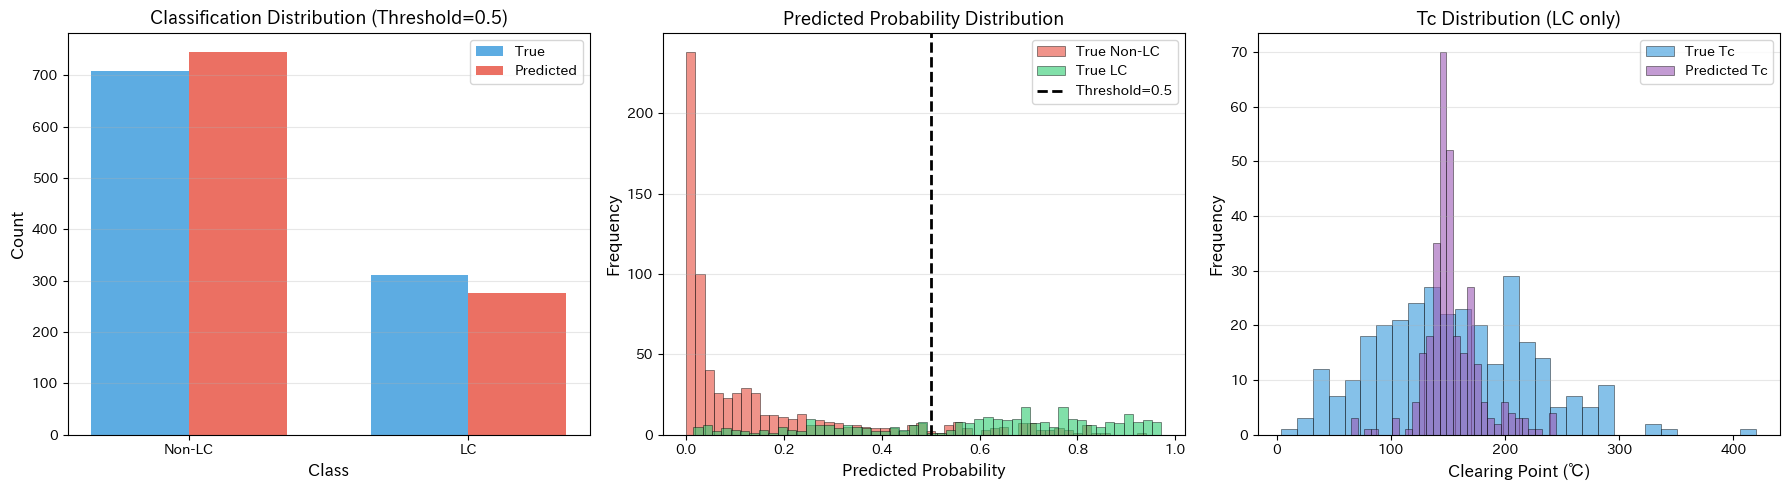

✅ 分布比較グラフを保存


In [11]:
# ==============================================
# 📊 1. 目的変数の分布比較（Train vs Pred）
# ==============================================
def plot_target_distribution_comparison(
    y_true_cls: np.ndarray,
    y_true_tc: np.ndarray,
    oof_prob: np.ndarray,
    oof_tc_pred: np.ndarray,
    figsize=(18, 5)
):
    """目的変数の分布を比較"""
    
    sep("📊 目的変数の分布比較")
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # === 1. 分類ラベルの分布 ===
    labels = ['Non-LC', 'LC']
    true_counts = [np.sum(y_true_cls == 0), np.sum(y_true_cls == 1)]
    pred_counts = [np.sum(oof_prob < 0.5), np.sum(oof_prob >= 0.5)]
    
    x = np.arange(len(labels))
    width = 0.35
    
    axes[0].bar(x - width/2, true_counts, width, label='True', alpha=0.8, color='#3498db')
    axes[0].bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8, color='#e74c3c')
    axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0].set_title('Classification Distribution (Threshold=0.5)', fontsize=13, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # === 2. 予測確率の分布 ===
    axes[1].hist(oof_prob[y_true_cls == 0], bins=50, alpha=0.6, color='#e74c3c', 
                 label='True Non-LC', edgecolor='black', linewidth=0.5)
    axes[1].hist(oof_prob[y_true_cls == 1], bins=50, alpha=0.6, color='#2ecc71', 
                 label='True LC', edgecolor='black', linewidth=0.5)
    axes[1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold=0.5')
    axes[1].set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1].set_title('Predicted Probability Distribution', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # === 3. 透明点の分布（液晶のみ） ===
    mask_lc = (y_true_cls == 1) & np.isfinite(y_true_tc) & np.isfinite(oof_tc_pred)
    
    if mask_lc.sum() > 0:
        axes[2].hist(y_true_tc[mask_lc], bins=30, alpha=0.6, color='#3498db', 
                     label='True Tc', edgecolor='black', linewidth=0.5)
        axes[2].hist(oof_tc_pred[mask_lc], bins=30, alpha=0.6, color='#9b59b6', 
                     label='Predicted Tc', edgecolor='black', linewidth=0.5)
        axes[2].set_xlabel('Clearing Point (℃)', fontsize=12, fontweight='bold')
        axes[2].set_ylabel('Frequency', fontsize=12, fontweight='bold')
        axes[2].set_title('Tc Distribution (LC only)', fontsize=13, fontweight='bold')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3, axis='y')
    else:
        axes[2].text(0.5, 0.5, 'No valid LC samples', 
                     ha='center', va='center', fontsize=14, transform=axes[2].transAxes)
    
    plt.tight_layout()
    plt.savefig(config.output_dir / 'target_distribution_comparison.png', dpi=config.viz.dpi, bbox_inches='tight')
    plt.show()
    
    print("✅ 分布比較グラフを保存")

# 実行
plot_target_distribution_comparison(
    df_train_processed['is_thermotropic_lc'].to_numpy().astype(int),
    df_train_processed['clearing_point_celsius'].to_numpy().astype(float),
    trainer.oof_predictions['classification'],
    trainer.oof_predictions['regression']
)

✨ 📊 Feature Importance


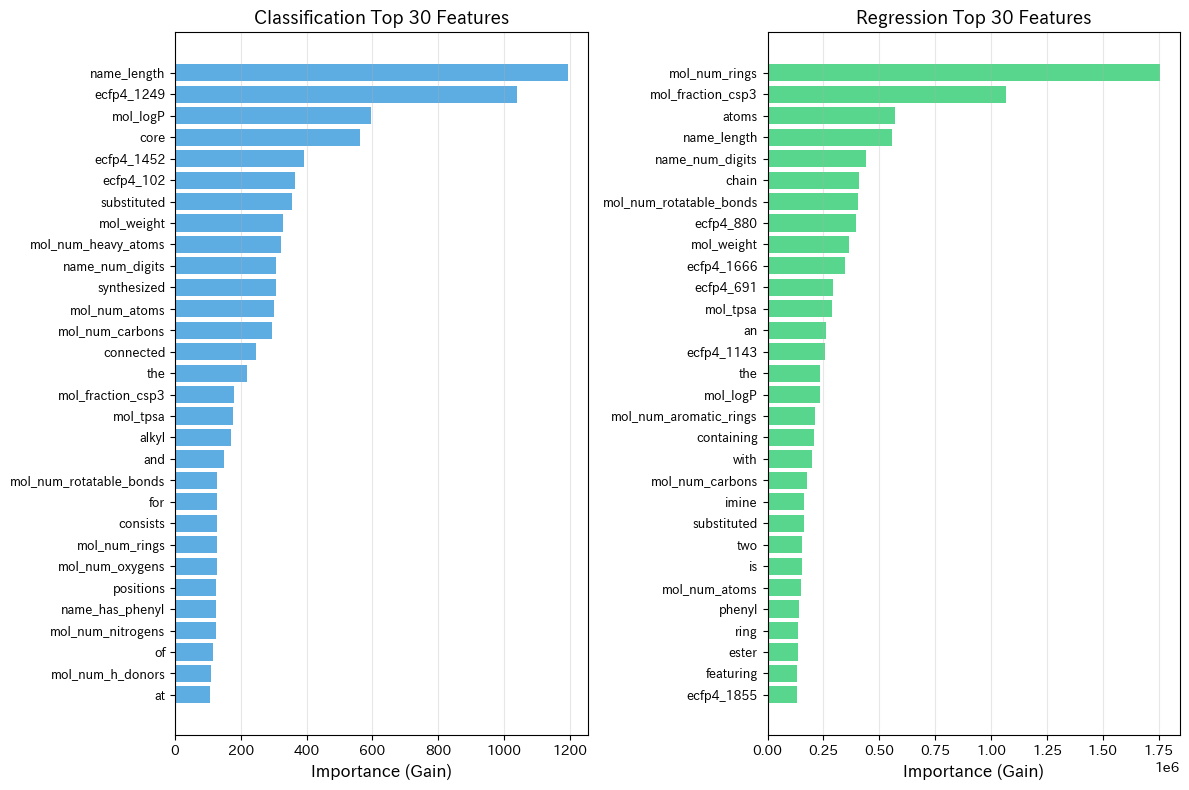

✅ Feature Importanceグラフを保存


In [12]:
# ==============================================
# 📊 2. Feature Importance 可視化
# ==============================================
def plot_feature_importance(
    feature_importance: Dict,
    top_n: int = 30,
    figsize=(12, 8)
):
    """Feature Importanceを可視化"""
    
    sep("📊 Feature Importance")
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # === 1. 分類タスク ===
    fi_cls = feature_importance['classification']
    feature_names = feature_importance['feature_names']
    
    idx_cls = np.argsort(fi_cls)[::-1][:top_n]
    
    axes[0].barh(range(len(idx_cls)), fi_cls[idx_cls], color='#3498db', alpha=0.8)
    axes[0].set_yticks(range(len(idx_cls)))
    axes[0].set_yticklabels([feature_names[i] for i in idx_cls], fontsize=9)
    axes[0].set_xlabel('Importance (Gain)', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Classification Top {top_n} Features', fontsize=13, fontweight='bold')
    axes[0].invert_yaxis()
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # === 2. 回帰タスク ===
    fi_tc = feature_importance['regression']
    idx_tc = np.argsort(fi_tc)[::-1][:top_n]
    
    axes[1].barh(range(len(idx_tc)), fi_tc[idx_tc], color='#2ecc71', alpha=0.8)
    axes[1].set_yticks(range(len(idx_tc)))
    axes[1].set_yticklabels([feature_names[i] for i in idx_tc], fontsize=9)
    axes[1].set_xlabel('Importance (Gain)', fontsize=12, fontweight='bold')
    axes[1].set_title(f'Regression Top {top_n} Features', fontsize=13, fontweight='bold')
    axes[1].invert_yaxis()
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(config.output_dir / 'feature_importance.png', dpi=config.viz.dpi, bbox_inches='tight')
    plt.show()
    
    print("✅ Feature Importanceグラフを保存")

# 実行
plot_feature_importance(trainer.feature_importance, top_n=config.viz.top_n_features)

✨ 📊 Confusion Matrix


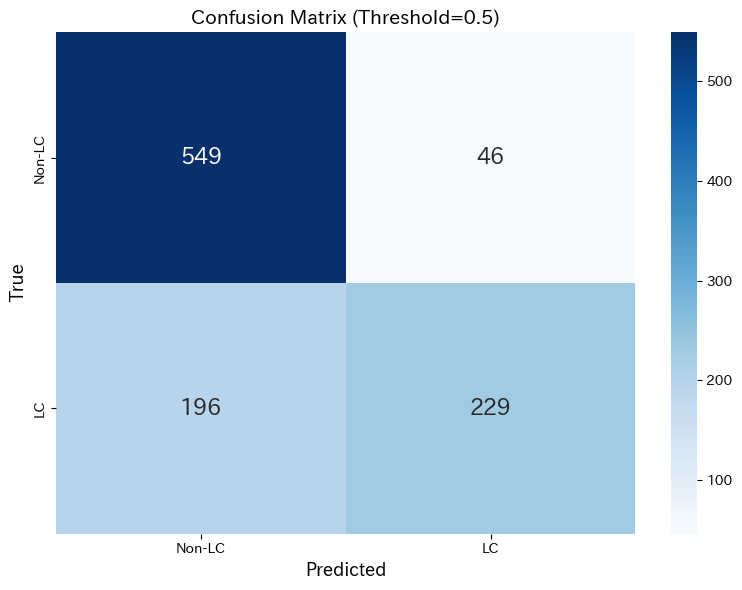


📈 分類性能指標 (Threshold=0.5):
   Accuracy:  0.76275
   Precision: 0.83273
   Recall:    0.53882
   F1 Score:  0.65429
   AUC:       0.84304

✅ Confusion Matrixを保存


In [13]:
# ==============================================
# 📊 3. Confusion Matrix 可視化
# ==============================================
def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred_prob: np.ndarray,
    threshold: float = 0.5,
    figsize=(8, 6)
):
    """Confusion Matrixを可視化"""
    
    sep("📊 Confusion Matrix")
    
    y_pred_binary = (y_pred_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_binary)
    
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues', cbar=True,
        xticklabels=['Non-LC', 'LC'], yticklabels=['Non-LC', 'LC'],
        ax=ax, annot_kws={'fontsize': 16, 'fontweight': 'bold'}
    )
    ax.set_xlabel('Predicted', fontsize=13, fontweight='bold')
    ax.set_ylabel('True', fontsize=13, fontweight='bold')
    ax.set_title(f'Confusion Matrix (Threshold={threshold})', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(config.output_dir / 'confusion_matrix.png', dpi=config.viz.dpi, bbox_inches='tight')
    plt.show()
    
    # 精度指標を表示
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    auc = roc_auc_score(y_true, y_pred_prob)
    
    print(f"\n📈 分類性能指標 (Threshold={threshold}):")
    print(f"   Accuracy:  {accuracy:.5f}")
    print(f"   Precision: {precision:.5f}")
    print(f"   Recall:    {recall:.5f}")
    print(f"   F1 Score:  {f1:.5f}")
    print(f"   AUC:       {auc:.5f}")
    
    print("\n✅ Confusion Matrixを保存")

# 実行
plot_confusion_matrix(
    df_train_processed['is_liquid_crystal'].to_numpy().astype(int),
    trainer.oof_predictions['classification']
)

✨ 📊 モデル性能の可視化


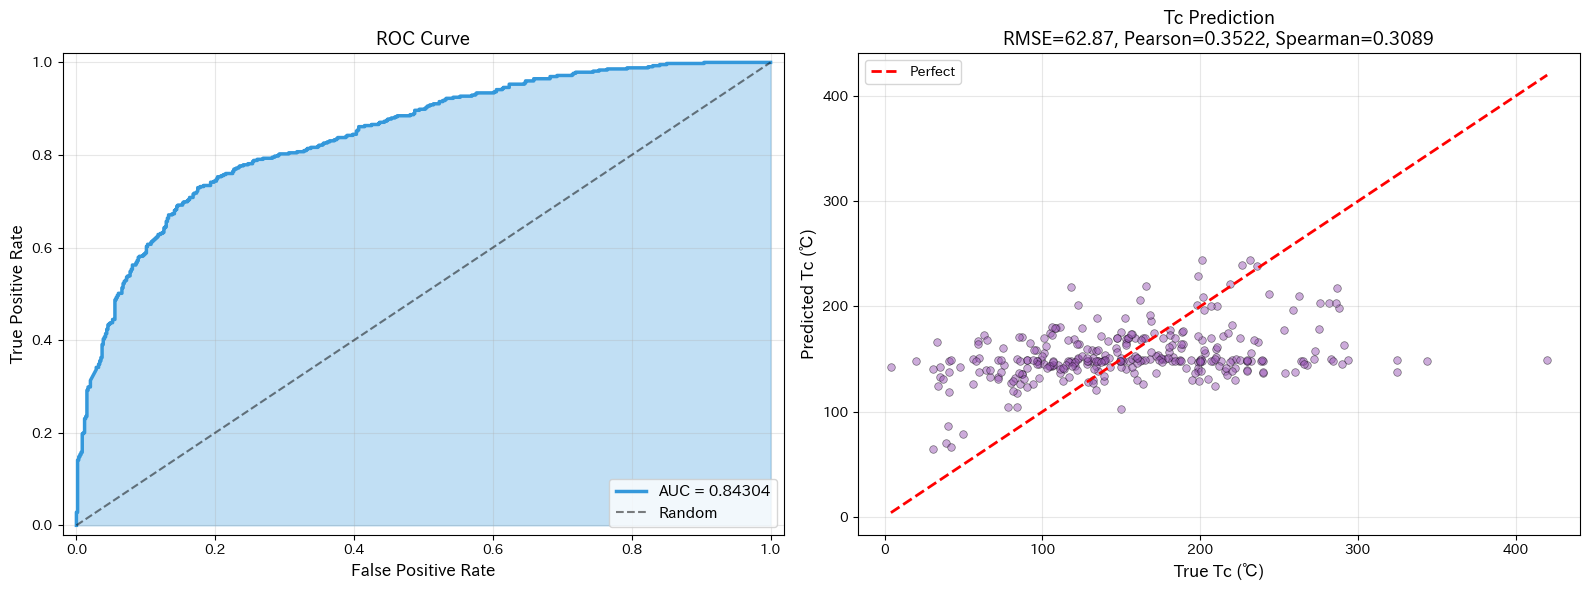

✅ モデル性能グラフを保存


In [14]:
# ==============================================
# 📊 4. ROC Curve & Tc Prediction Scatter
# ==============================================
def plot_model_performance(
    y_true_cls: np.ndarray,
    y_true_tc: np.ndarray,
    oof_prob: np.ndarray,
    oof_tc_pred: np.ndarray,
    figsize=(16, 6)
):
    """ROC CurveとTc予測の散布図"""
    
    sep("📊 モデル性能の可視化")
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # === 1. ROC Curve ===
    fpr, tpr, _ = roc_curve(y_true_cls, oof_prob)
    auc = roc_auc_score(y_true_cls, oof_prob)
    
    axes[0].plot(fpr, tpr, color='#3498db', linewidth=2.5, label=f'AUC = {auc:.5f}')
    axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random')
    axes[0].fill_between(fpr, tpr, alpha=0.3, color='#3498db')
    axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    axes[0].set_title('ROC Curve', fontsize=13, fontweight='bold')
    axes[0].legend(loc='lower right', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim([-0.02, 1.02])
    axes[0].set_ylim([-0.02, 1.02])
    
    # === 2. Tc Prediction Scatter ===
    mask_lc = (y_true_cls == 1) & np.isfinite(y_true_tc) & np.isfinite(oof_tc_pred)
    
    if mask_lc.sum() > 0:
        y_tc_lc = y_true_tc[mask_lc]
        oof_tc_lc = oof_tc_pred[mask_lc]
        
        axes[1].scatter(y_tc_lc, oof_tc_lc, alpha=0.5, s=30, color='#9b59b6', 
                       edgecolor='black', linewidth=0.5)
        
        min_val = min(y_tc_lc.min(), oof_tc_lc.min())
        max_val = max(y_tc_lc.max(), oof_tc_lc.max())
        axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', 
                    linewidth=2, label='Perfect')
        
        rmse = np.sqrt(np.mean((y_tc_lc - oof_tc_lc) ** 2))
        from scipy.stats import pearsonr, spearmanr
        pearson_r, _ = pearsonr(y_tc_lc, oof_tc_lc)
        spearman_r, _ = spearmanr(y_tc_lc, oof_tc_lc)
        
        axes[1].set_xlabel('True Tc (℃)', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Predicted Tc (℃)', fontsize=12, fontweight='bold')
        axes[1].set_title(
            f'Tc Prediction\nRMSE={rmse:.2f}, Pearson={pearson_r:.4f}, Spearman={spearman_r:.4f}',
            fontsize=13, fontweight='bold'
        )
        axes[1].legend(loc='upper left', fontsize=10)
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No valid LC samples', 
                     ha='center', va='center', fontsize=14, 
                     transform=axes[1].transAxes)
    
    plt.tight_layout()
    plt.savefig(config.output_dir / 'model_performance.png', 
                dpi=config.viz.dpi, bbox_inches='tight')
    plt.show()
    
    print("✅ モデル性能グラフを保存")

# 実行
plot_model_performance(
    df_train_processed['is_liquid_crystal'].to_numpy().astype(int),
    df_train_processed['clearing_point_celsius'].to_numpy().astype(float),
    trainer.oof_predictions['classification'],
    trainer.oof_predictions['regression']
)

In [15]:
# ==============================================
# 📊 5. 最終サマリー表示
# ==============================================
sep("🎉 全ての処理が完了しました！")

print(f"\n📊 最終CVスコア:")
print(f"   Decoupled Rank Score: {results['cv_score']:.6f}")
print(f"   Normalized Gini:      {results['cv_gini']:.6f}")
print(f"   Spearman's rho:       {results['cv_rho']:.6f}")

print(f"\n📈 Fold別スコア:")
fold_df = pd.DataFrame(results['fold_scores'])
display(fold_df)

print(f"\n💾 保存されたファイル:")
saved_files = [
    ('OOF predictions', 'oof_predictions.csv'),
    ('Submission', 'submission.csv'),
    ('Target distribution', 'target_distribution_comparison.png'),
    ('Feature importance', 'feature_importance.png'),
    ('Confusion matrix', 'confusion_matrix.png'),
    ('Model performance', 'model_performance.png'),
]

for name, filename in saved_files:
    print(f"   ✅ {name:25s}: {config.output_dir / filename}")

if config.wandb.use_wandb:
    print(f"\n🔗 W&B:")
    print(f"   Project: {config.wandb.project}")
    print(f"   Group:   {config.wandb.base_group}")
    print(f"   URL:     https://toyota.wandb.io/{config.wandb.entity}/{config.wandb.project}")

print(f"\n✨ 完了時刻: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*80)

✨ 🎉 全ての処理が完了しました！

📊 最終CVスコア:
   Decoupled Rank Score: 0.154201
   Normalized Gini:      -0.000545
   Spearman's rho:       0.308947

📈 Fold別スコア:


,fold,score,norm_gini,spearman,auc
0,1,0.241015,-0.001884,0.483914,0.791296
1,2,-0.012422,-0.002481,-0.022362,0.906029
2,3,0.132141,-0.002588,0.266870,0.948462
3,4,0.094294,-0.003240,0.191827,0.923516
4,5,0.251804,-0.003808,0.507416,0.933333



💾 保存されたファイル:
   ✅ OOF predictions          : /kaggle/working/oof_predictions.csv
   ✅ Submission               : /kaggle/working/submission.csv
   ✅ Target distribution      : /kaggle/working/target_distribution_comparison.png
   ✅ Feature importance       : /kaggle/working/feature_importance.png
   ✅ Confusion matrix         : /kaggle/working/confusion_matrix.png
   ✅ Model performance        : /kaggle/working/model_performance.png

🔗 W&B:
   Project: DSOW2025-improved-baseline
   Group:   lc-improved-20251226-055551
   URL:     https://toyota.wandb.io/hidebu/DSOW2025-improved-baseline

✨ 完了時刻: 2025-12-26 05:57:34


---
# 📋 改良版コードのまとめ

## ✅ 実装した改善点

### 1️⃣ **Config の統合・拡張**
- すべての設定を `Config` クラスで一元管理
- Preprocessor、モデル（LGBM）、W&B、可視化の設定を追加
- パラメータ調整が容易に

### 2️⃣ **LiquidCrystalPreprocessor の改善**
- Config ベースでの制御が可能に
- ECFP4・TF-IDF を**密行列**として出力し、他の特徴量と結合
- 疎行列を返さない設計に変更（メモリ効率より統合性を優先）
- `fit_transform()` と `transform()` で一貫した処理

### 3️⃣ **モデル学習の改善**
- **正しい目的変数**を使用：
  - 分類: `is_liquid_crystal`
  - 回帰: `clearing_point_celsius`
- **入力変数の追加**：
  - カテゴリカル変数（`lc_type`, `phase_transition_behavior`, `smiles_source`）を LabelEncoding
  - `is_thermotropic_lc` も特徴量として追加
  - Preprocessor で作成した全特徴量を使用
- **OOF予測の保存**：
  - `/kaggle/working/oof_predictions.csv` に保存
  - W&B にも Artifact としてアップロード

### 4️⃣ **可視化・分析の追加**
- **目的変数の分布比較**（Train vs Pred）
  - 分類ラベルの分布
  - 予測確率の分布
  - 透明点の分布（液晶のみ）
- **Feature Importance の可視化**
  - 分類タスク Top 30
  - 回帰タスク Top 30
- **Confusion Matrix の可視化**
  - ヒートマップ形式
  - Accuracy, Precision, Recall, F1-Score も表示
- **モデル性能の可視化**
  - ROC Curve（AUC付き）
  - Tc予測の散布図（RMSE, Pearson, Spearman付き）

### 5️⃣ **コードの可読性向上**
- `sep()`, `show_df()` などのヘルパー関数を活用
- 絵文字を使った視覚的なセクション分け
- `tqdm` によるプログレスバー表示
- 適切なコメントと docstring

## 🎯 使用方法

### 基本的な使い方
```python
# 1. Config でパラメータを調整
config = Config()
config.preprocessor.n_bits = 4096  # ECFP4のビット数を変更
config.model.classification['learning_rate'] = 0.03  # 学習率を変更

# 2. すべてのセルを順番に実行
# 3. 結果は /kaggle/working に保存される
```

### カスタマイズ例
```python
# W&Bを無効化する場合
config.wandb.use_wandb = False

# 特徴量を選択する場合
config.preprocessor.include_ecfp4 = False  # ECFP4を使わない
config.preprocessor.include_tfidf = True   # TF-IDFは使う

# Fold数を変更
config.n_splits = 10
```

## 📊 出力ファイル一覧

| ファイル名 | 説明 |
|:---|:---|
| `oof_predictions.csv` | OOF予測値（CV検証用） |
| `submission.csv` | Kaggle提出用ファイル |
| `target_distribution_comparison.png` | 目的変数の分布比較 |
| `feature_importance.png` | 特徴量重要度（分類・回帰） |
| `confusion_matrix.png` | 混同行列 |
| `model_performance.png` | ROC Curve & Tc予測 |

## 🔧 今後の改善案

- [ ] Optuna によるハイパーパラメータチューニング
- [ ] Ensemble（複数モデルの平均）
- [ ] より高度な特徴量エンジニアリング
- [ ] アンサンブル学習（XGBoost, CatBoost との組み合わせ）
- [ ] Pseudo Labeling（テストデータの活用）

---

**🎉 これで改良版コードは完成です！**

すべての要件を満たし、可読性と保守性の高いコードになりました。
Kaggle Notebook で実行すると、学習から可視化まで一貫して処理されます。